In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

In [ ]:
!pip install stable-baselines3[extra] protobuf

In [ ]:
!pip install mss pydirectinput pytesseract

In [2]:
from mss import mss
import pydirectinput
import cv2
import numpy as np
import pytesseract
from matplotlib import pyplot as plt 
import time
from gymnasium import Env
from gymnasium.spaces import Box, Discrete
import os
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker

Budowanie środowiska

In [16]:
class ZenithJump(Env):
    # Set up the environment action and observation space
    def __init__(self):
        #Subclass model
        super().__init__()
        # setup spaces
        self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
        self.action_space = Discrete(3)
        # Define extraction parameters for the  game
        self.cap = mss()
        self.game_location = {'top': 155, 'left': 710, 'width': 500, 'height': 760}
        self.done_location = {'top': 410, 'left': 850, 'width': 250, 'height': 50}
        self.score_location = {'top': 170, 'left': 800, 'width': 80, 'height': 25}

    # What is called to do something in game
    def step(self, action):
        # Action key - 0 = Space, 1 = Duck, 2 = Do nothing
        action = action.item()
        action_map = {0: 'left', 1: 'right', 2: 'no_op'}
        if action != 2:
            pydirectinput.press(action_map[action])

        # checking if game is done
        done, done_cap = self.get_done()
        truncated = False
        # get next observation
        new_observation = self.get_observation()
        # Reward - point for every frame we are alive
        score, score_cap = self.get_score()
        reward = score - self.last_score
        self.last_score = score

        info = {"score": score}

        return new_observation, reward, done, truncated, info

    # Visualize the game
    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()

    # Restart the game
    def reset(self, seed=None):
        time.sleep(0.25)
        pydirectinput.click(x=900,y=500)
        pydirectinput.press('space')
        self.last_score = 0
        info = {}
        return self.get_observation(),info

    # This closes down the obseration space
    def close(self):
        cv2.destroyAllWindows()
    # Get the part of the observation space
    def get_observation(self):
        # Get screen capture of game that we want
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3]
        # Convert to grey scale
        grey = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        # Resize the image
        resized = cv2.resize(grey, (100, 83))
        # Add channels first
        channel = np.reshape(resized, (1, 83, 100))
        return channel
    
    def get_score(self):
        # Get screen capture of the score area
        score_cap = np.array(self.cap.grab(self.score_location))[:, :, :3]
        # Use OCR to get the text
        score_str = pytesseract.image_to_string(score_cap, config='--psm 7 digits')
        # Extract numbers from the string
        score = ''.join(filter(str.isdigit, score_str))
        # Convert to integer if possible
        score = int(score) if score.isdigit() else 0
        return score, score_cap
    
    
    # Get the done text using OCR
    def get_done(self):
        # Get done screen
        done_cup = np.array(self.cap.grab(self.done_location))[:,:,:3]
        # Valid done text
        done_strings = ["GAME", "GAHE", "GAM", "GA"]

        # Use OCR to get the text
        done = False
        res = pytesseract.image_to_string(done_cup)[:4]
        if res in done_strings:
            done = True

        return done,done_cup

In [17]:
env = ZenithJump()

In [12]:
score, score_cap = env.get_score()

In [13]:
score

1004

''

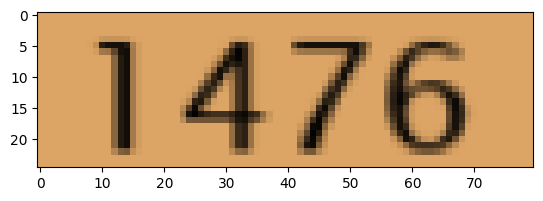

In [117]:
env = ZenithJump()
res, done_cap = env.get_score()
plt.imshow(done_cap)
res

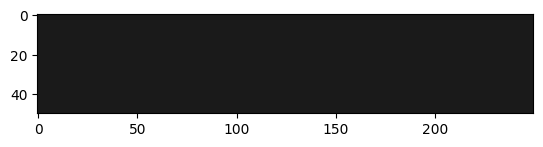

In [49]:
env = ZenithJump()
done, done_cap = env.get_done()
plt.imshow(done_cap)

In [40]:
done
pytesseract.image_to_string(done_cap)[:4]

''

In [42]:
env_checker.check_env(env)

In [18]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, "best_model_{}".format(self.n_calls))
            self.model.save(model_path)
        
        return True

In [19]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'

In [20]:
callabck = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

In [21]:
from stable_baselines3 import DQN

In [24]:
model = DQN("CnnPolicy", env, verbose=1, tensorboard_log=LOG_DIR, buffer_size=500000, learning_starts=1000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\48573\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 8.31GB > 2.92GB
  warnings.warn(


In [25]:
#kick of training
model.learn(total_timesteps=50000, callback=callabck)

Logging to ./logs/DQN_9
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.25     |
|    ep_rew_mean      | 0        |
|    exploration_rate | 0.996    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1        |
|    time_elapsed     | 12       |
|    total_timesteps  | 21       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.88     |
|    ep_rew_mean      | 8.62     |
|    exploration_rate | 0.993    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1        |
|    time_elapsed     | 23       |
|    total_timesteps  | 39       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 4.58     |
|    ep_rew_mean      | 32.4     |
|    exploration_rate | 0.99     |
| time/               |        

KeyboardInterrupt: 

In [118]:
for episode in range(1):
    obs = env.reset()
    done = False
    total_reward = 0
    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, truncated, info = env.step(env.action_space.sample())
        total_reward += reward
    print(f"Episode {episode} finished with reward: {total_reward}")

ValueError: You have passed a tuple to the predict() function instead of a Numpy array or a Dict. You are probably mixing Gym API with SB3 VecEnv API: `obs, info = env.reset()` (Gym) vs `obs = vec_env.reset()` (SB3 VecEnv). See related issue https://github.com/DLR-RM/stable-baselines3/issues/1694 and documentation for more information: https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecenv-api-vs-gym-api